In [2]:
%reload_ext autoreload
%autoreload 2

In [33]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.readout import predict_downstream
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## locate sessions with PFC or MEC

In [107]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)
    
sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA10\day27
1,Z:\Data\AYAold\AYA10\day31
2,Z:\Data\AYAold\AYA10\day32
3,Z:\Data\AYAold\AYA7\day19
4,Z:\Data\AYAold\AYA7\day20
...,...
106,Z:\Data\FujisawaS\EE\EE0627fm
107,Z:\Data\FujisawaS\EE\EE0705fm
108,Z:\Data\FujisawaS\EE\EE0706fm
109,Z:\Data\FujisawaS\EE\EE0708fm


In [114]:
X.shape

(2231, 35)

In [116]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\predict_downstream_v1"
)

batch_analysis.run(
    df_sessions,
    save_path,
    predict_downstream.run,
    parallel=False,
    verbose=True,
)
# load results
df_layer_bias = predict_downstream.load_results(save_path)
# basepath = r"Z:\Data\HMC1\day13"

# results = predict_downstream.run(
#     basepath
# )

  0%|          | 0/111 [00:00<?, ?it/s]

Z:\Data\AYAold\AYA10\day27
Z:\Data\AYAold\AYA10\day31
Z:\Data\AYAold\AYA10\day32
Z:\Data\AYAold\AYA7\day19


  3%|▎         | 3/111 [00:06<04:02,  2.24s/it]


ValueError: Found array with 0 feature(s) (shape=(688, 0)) while a minimum of 1 is required by StandardScaler.

In [104]:
results

,epoch,epoch_i,targ_reg,n_x_components,mse,mean_score,std_score,test_score,train_score,n_deep,n_sup,n_target_cells,basepath
0,sleep,0,PFC,42,0.083406,0.004301,0.032611,0.019452,0.058981,71,36,177,Z:\Data\HMC1\day13
1,sleep,0,EC1|EC2|EC3|EC4|EC5|MEC,26,0.084177,0.008347,0.011878,0.010395,0.042449,71,36,111,Z:\Data\HMC1\day13
2,linear,1,PFC,39,0.207105,-1.267854,0.527340,-0.861735,0.831462,71,36,177,Z:\Data\HMC1\day13
3,linear,1,EC1|EC2|EC3|EC4|EC5|MEC,32,0.215578,-0.506850,0.193268,-0.937902,0.816408,71,36,111,Z:\Data\HMC1\day13
4,sleep,2,PFC,45,0.063631,-0.055760,0.046401,0.055575,0.088320,71,36,177,Z:\Data\HMC1\day13
5,sleep,2,EC1|EC2|EC3|EC4|EC5|MEC,29,0.064630,-0.068475,0.062540,0.040741,0.096383,71,36,111,Z:\Data\HMC1\day13


## Testing below

In [64]:
basepath = r"Z:\Data\HMC1\day8"

st, cell_metrics = loading.load_spikes(basepath,brainRegion=["CA1","PFC","MEC"])
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)

ripples = loading.load_ripples_events(basepath)
ripple_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T]).expand(0.1)

ep_df = loading.load_epoch(basepath)
ep_epochs = nel.EpochArray([np.array([ep_df.startTime, ep_df.stopTime]).T])

In [65]:
st = st[ep_epochs[0]]
ripple_epochs = ripple_epochs[ep_epochs[0]]

In [224]:
st_par = functions.get_participation(
    st.data,
    ripple_epochs.starts,
    ripple_epochs.stops,
    par_type="binary",
)

In [66]:
ca1_deep_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)
ca1_sup_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Superficial")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)

In [67]:
target_regions=["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"]  # regions to compare ref to

for region in target_regions:
    print(sum(cell_metrics.brainRegion.str.contains(region).values))
    sum(cell_metrics.brainRegion.str.contains(region).values)

175
75


<AxesSubplot:>

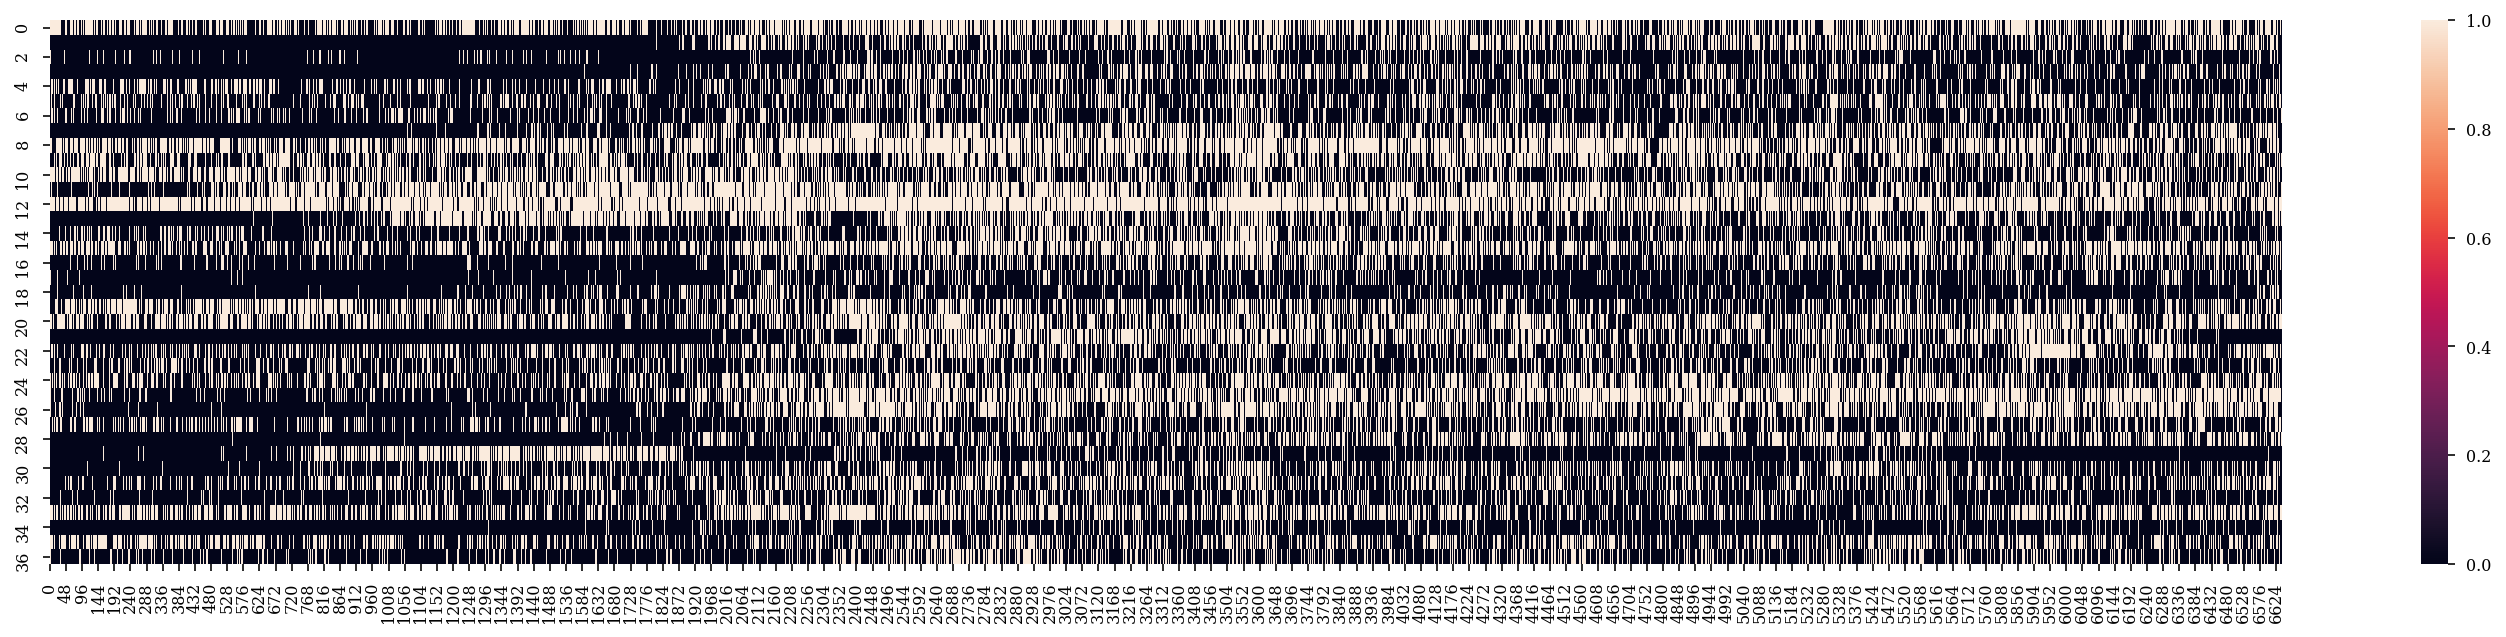

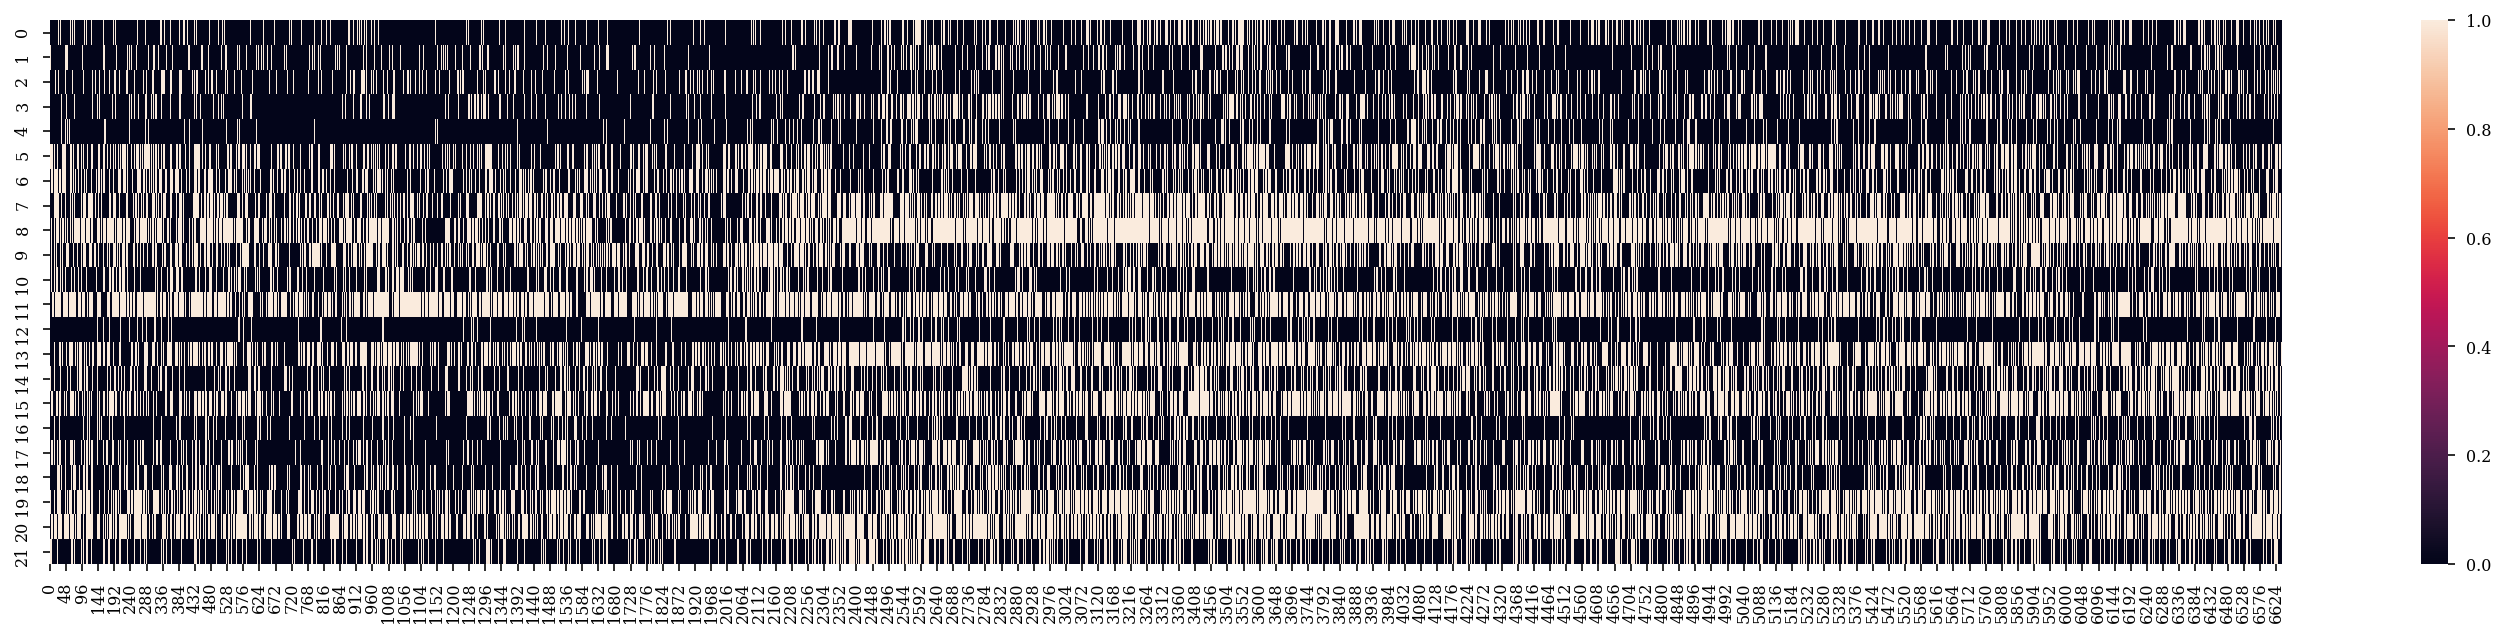

In [228]:
plt.figure(figsize=(25,5))
sns.heatmap(st_par[ca1_deep_idx,:])

plt.figure(figsize=(25,5))
sns.heatmap(st_par[ca1_sup_idx,:])

In [68]:
ca1_deep_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Deep")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)
ca1_sup_idx = (
    cell_metrics.brainRegion.str.contains("CA1").values
    & (cell_metrics.deepSuperficial == "Superficial")
    & (cell_metrics.putativeCellType.str.contains("Pyr"))
)

ca1_deep_par = functions.get_participation(
    st.iloc[:, ca1_deep_idx].data,
    ripple_epochs.starts,
    ripple_epochs.stops,
    par_type="binary",
)
ca1_sup_par = functions.get_participation(
    st.iloc[:, ca1_sup_idx].data,
    ripple_epochs.starts,
    ripple_epochs.stops,
    par_type="binary",
)
deep_sup_ratio = ca1_deep_par.sum(axis=0) / ca1_sup_par.sum(axis=0)
# deep_sup_ratio = ca1_deep_par.mean(axis=0) / ca1_sup_par.mean(axis=0)
# deep_sup_ratio = (ca1_deep_par.sum(axis=0) - ca1_sup_par.sum(axis=0)) / (ca1_deep_par.sum(axis=0) + ca1_sup_par.sum(axis=0))


In [69]:
pfc_deep_idx = cell_metrics.brainRegion.str.contains("PFC").values
mec_sup_idx = cell_metrics.brainRegion.str.contains("MEC").values

pfc_par = functions.get_participation(st.iloc[:,pfc_deep_idx].data,ripple_epochs.starts, ripple_epochs.stops,par_type="binary")
mec_par = functions.get_participation(st.iloc[:,mec_sup_idx].data,ripple_epochs.starts, ripple_epochs.stops,par_type="binary")

<AxesSubplot:>

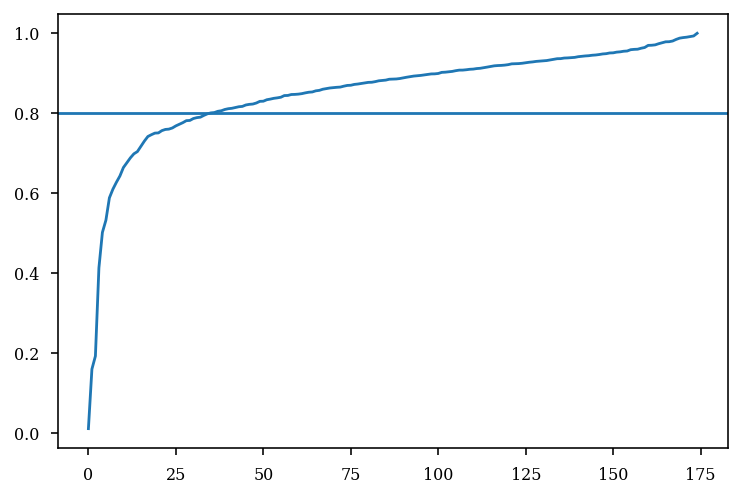

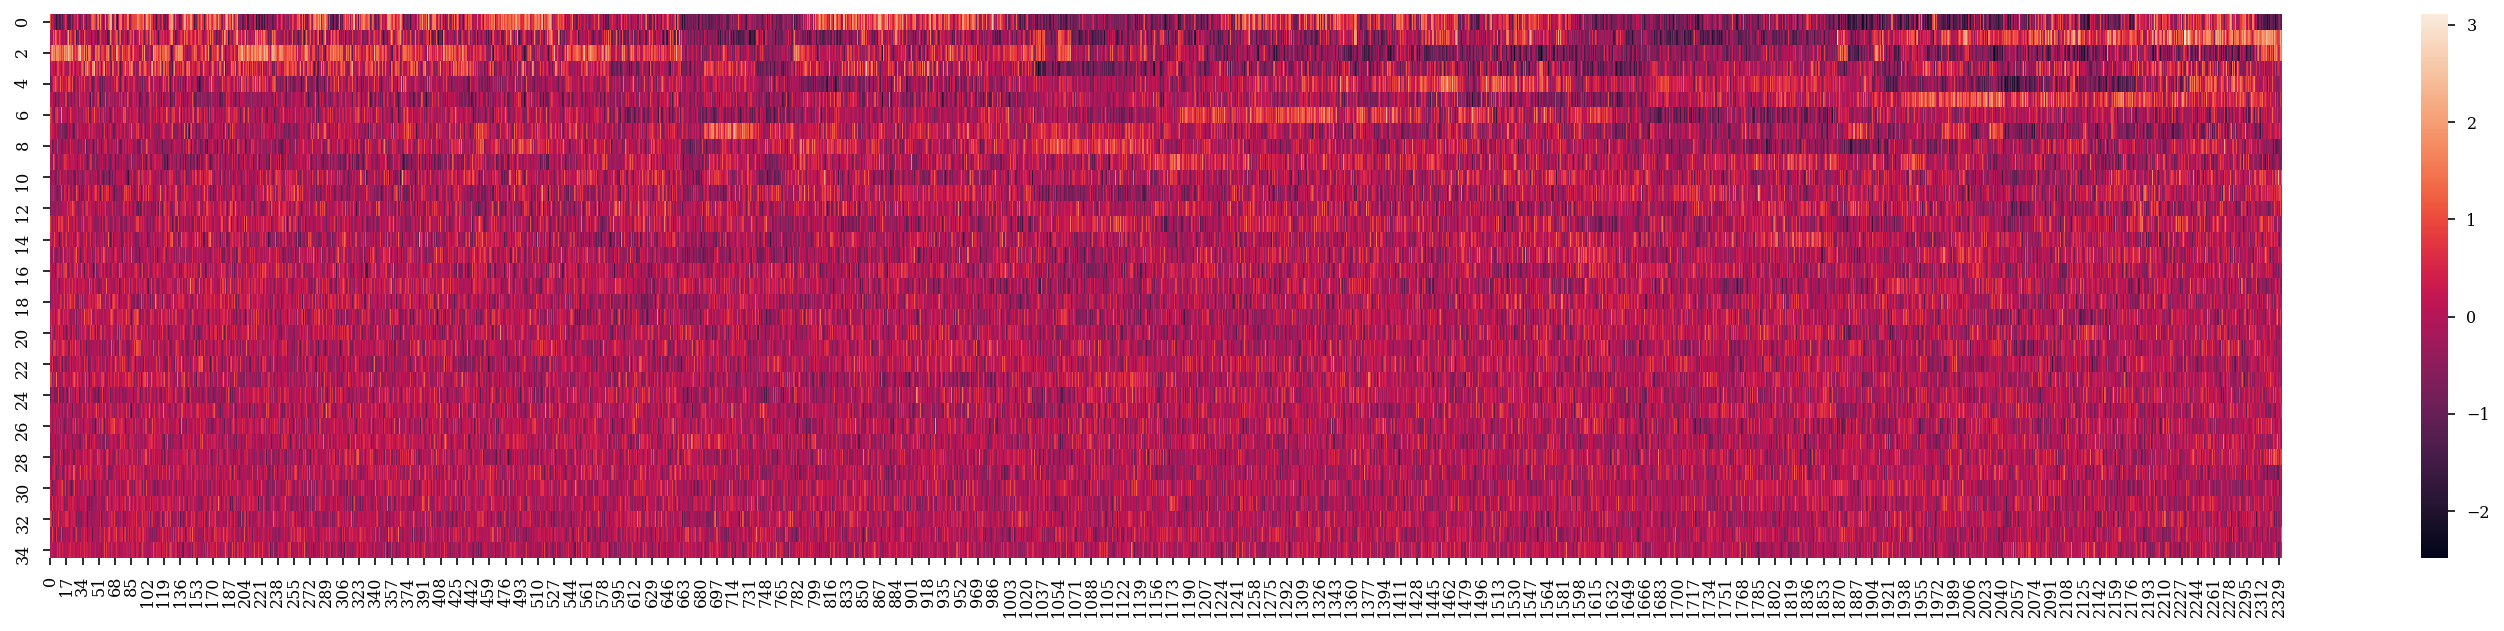

In [70]:
from sklearn.decomposition import PCA
# pfc_par
pca = PCA().fit(pfc_par.T)
plt.plot(1-pca.explained_variance_)
plt.axhline(.8)

n_components = np.where(1-pca.explained_variance_ >= .8)[0][0]

X_transformed = PCA(n_components=n_components).fit_transform(pfc_par.T)
plt.figure(figsize=(25,5))
sns.heatmap(X_transformed.T)

In [50]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=10)
X_transformed = embedding.fit_transform(pfc_par.T)

X_transformed.shape

(2332, 10)

<AxesSubplot:>

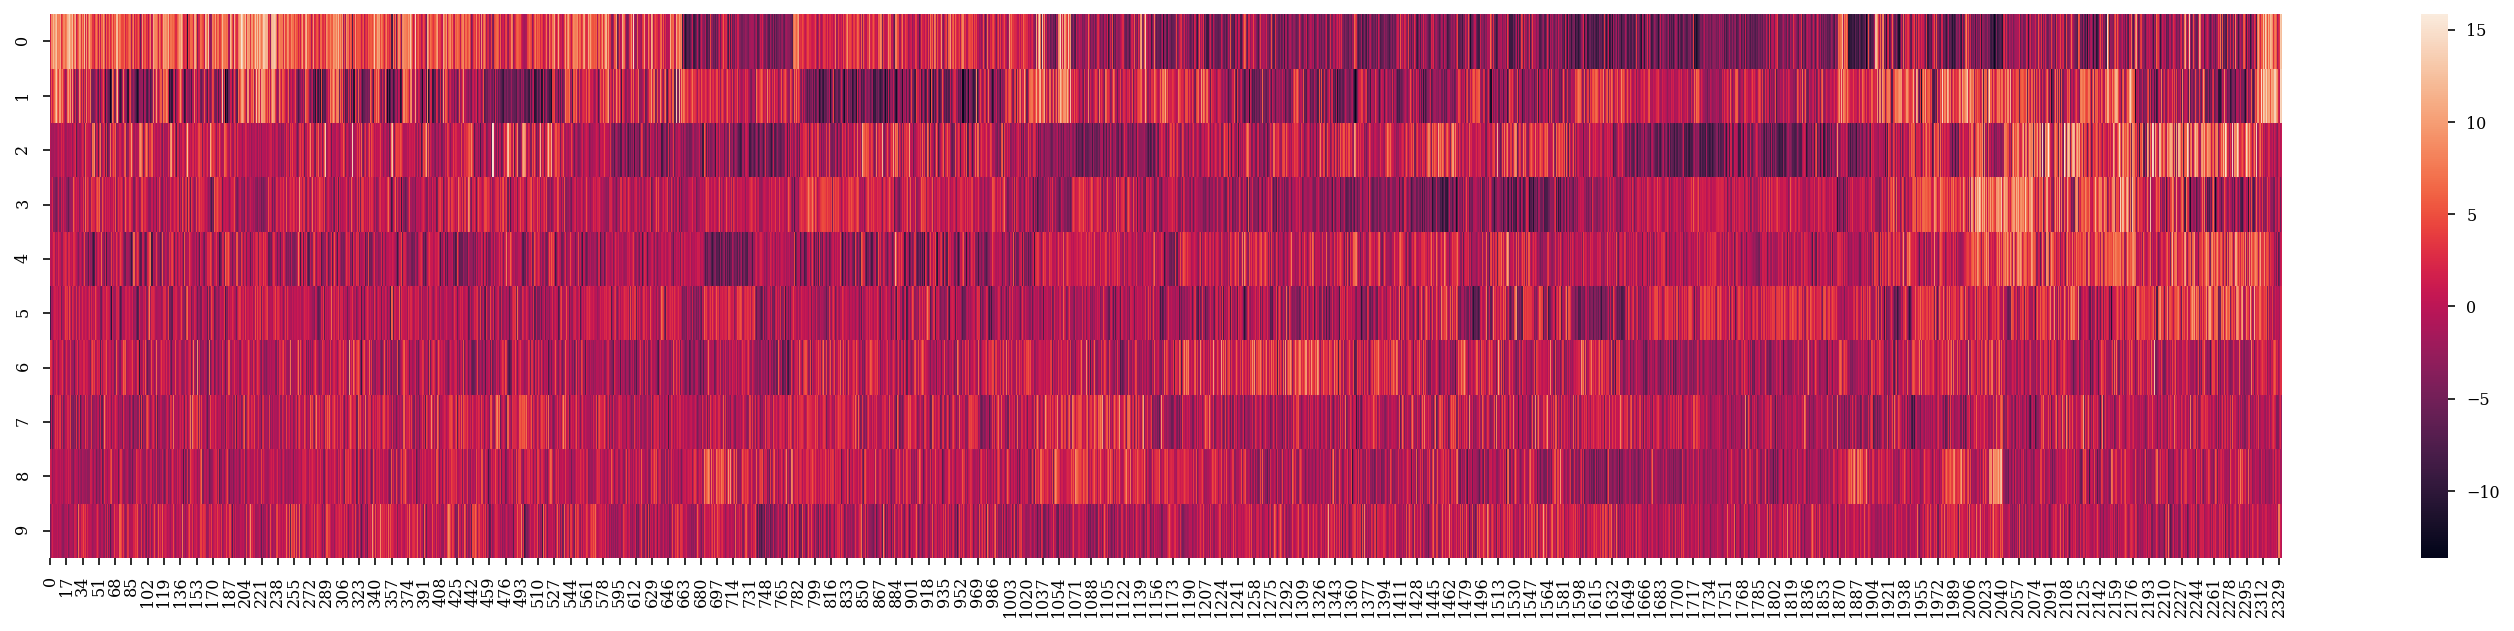

In [51]:
plt.figure(figsize=(25,5))
sns.heatmap(X_transformed.T)

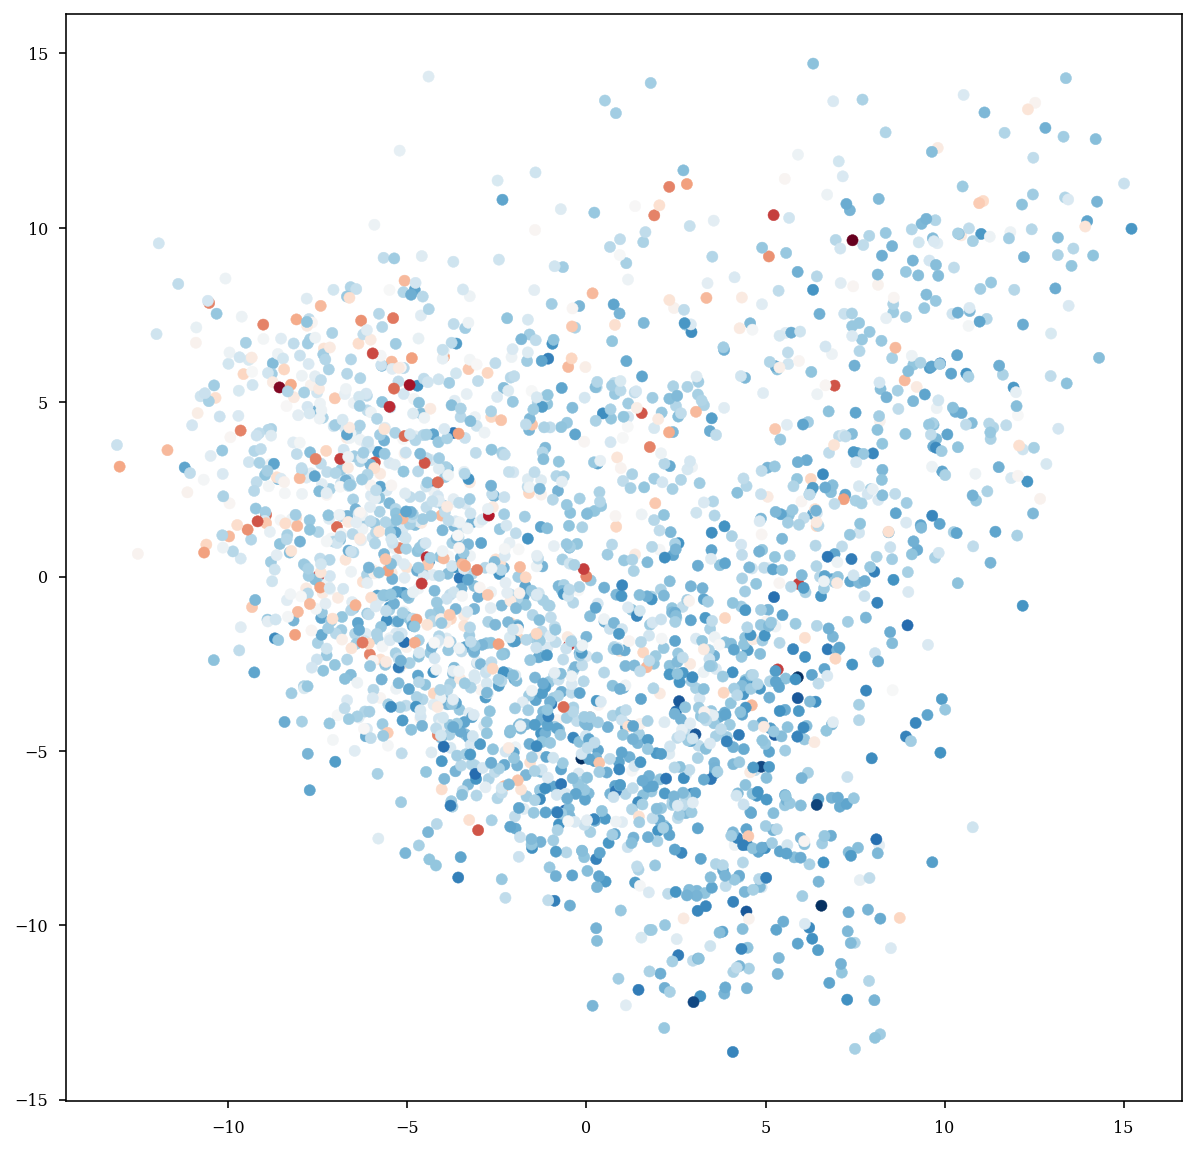

In [256]:
plt.figure(figsize=(10,10))
plt.scatter(X_transformed[:,0],X_transformed[:,1],c=np.log(deep_sup_ratio+1),cmap="RdBu_r")

<AxesSubplot:>

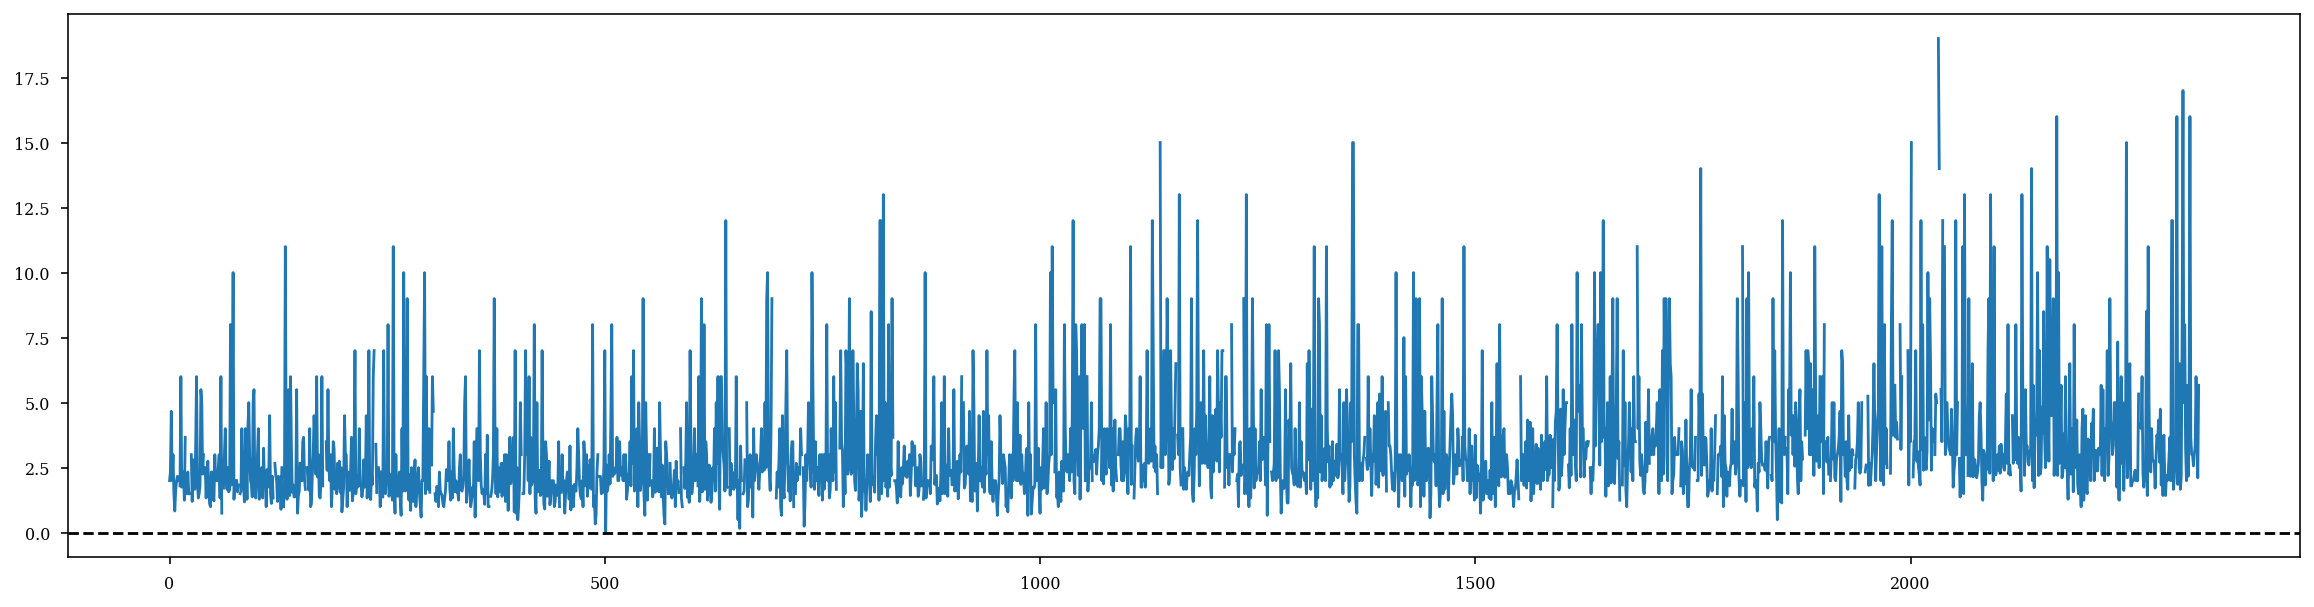

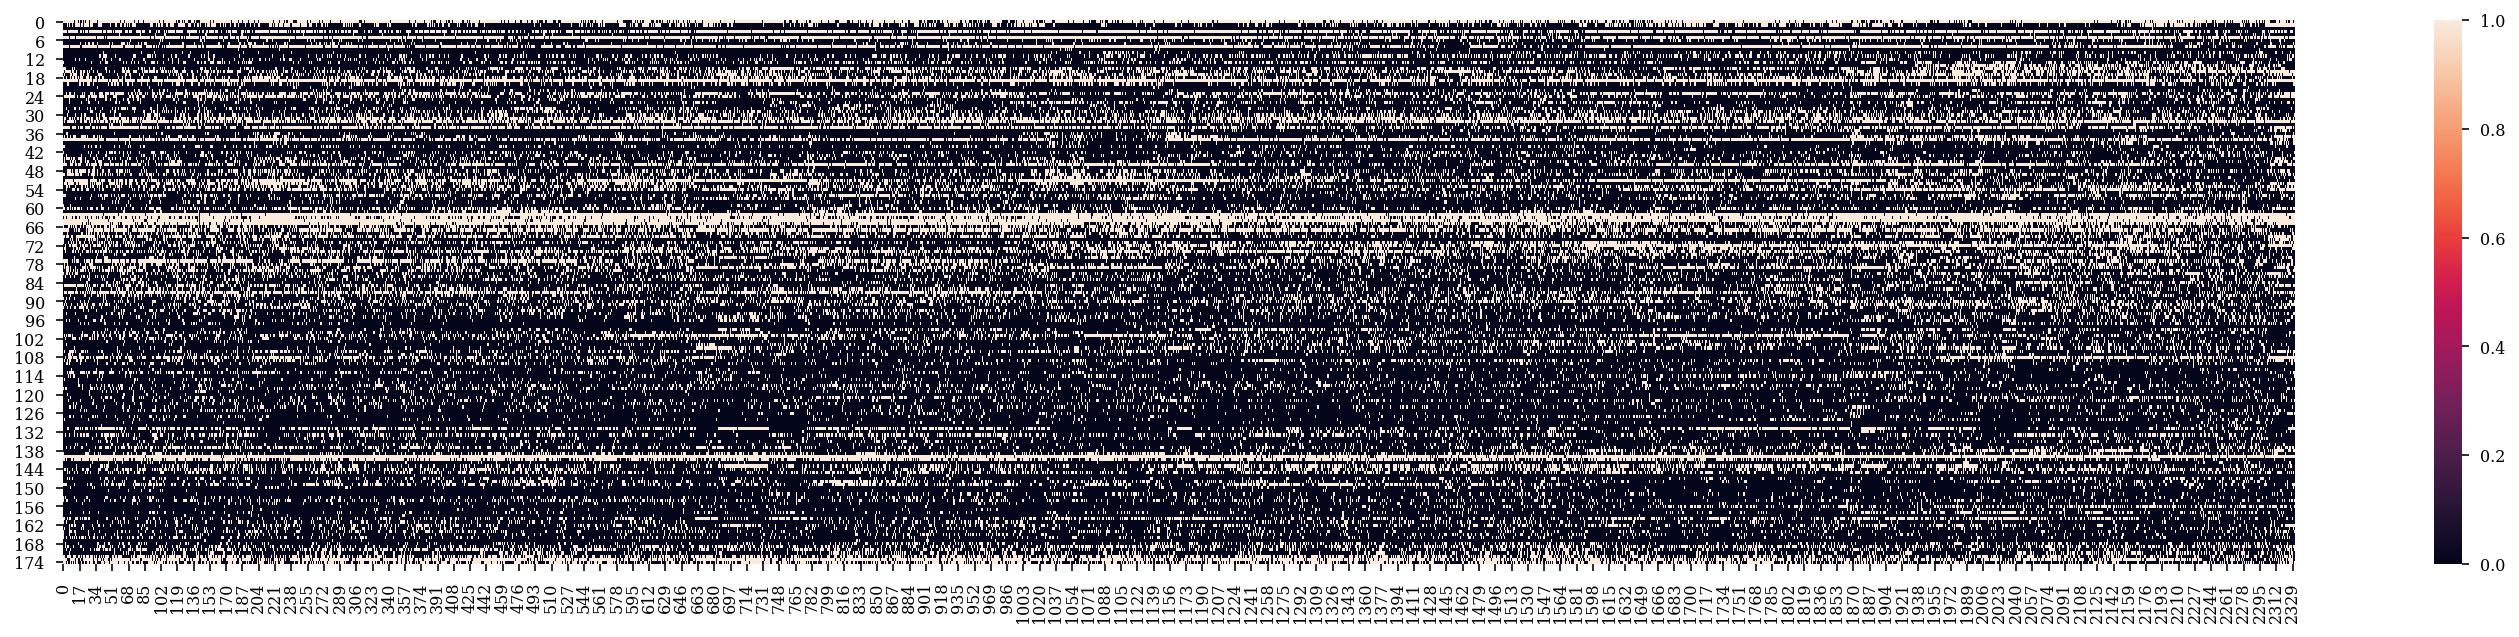

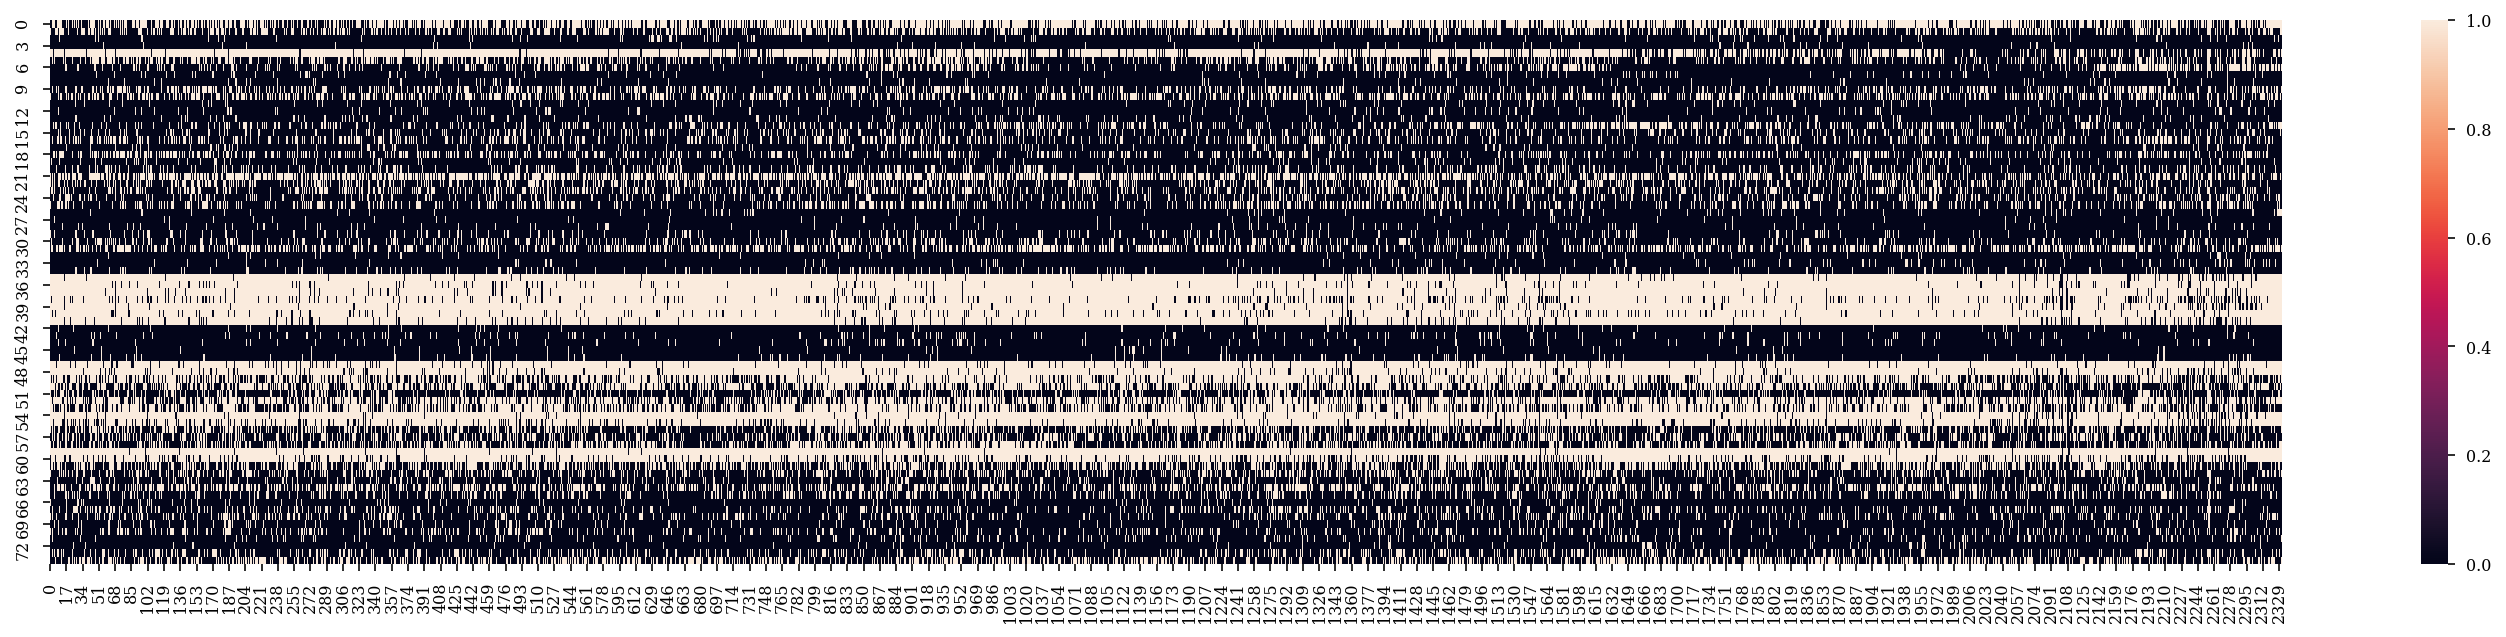

In [24]:
plt.figure(figsize=(20,5))
plt.plot(deep_sup_ratio)
plt.axhline(0,color="k",linestyle="--")
plt.figure(figsize=(25,5))
sns.heatmap(pfc_par)
plt.figure(figsize=(25,5))
sns.heatmap(mec_par)

In [ ]:
df = pd.DataFrame(mec_par.T)
# df["mec_par"] = mec_par
df["target"] = deep_sup_ratio
df

corr = df.corr()['target'][df.corr()['target'] < 1].abs()
# corr.sort(ascending=False)
# corr.head()
idx = np.argsort(-corr)

corr[idx]


In [71]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

# X = pfc_par.T
X = X_transformed
y = np.log(deep_sup_ratio+1).reshape(-1,1)
# y = deep_sup_ratio.reshape(-1,1)

bad_idx = np.isinf(deep_sup_ratio) | np.isnan(deep_sup_ratio)
y = y[~bad_idx]
X = X[~bad_idx]

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


In [72]:
X.shape

(2231, 35)

In [102]:
from sklearn.linear_model import RidgeCV
reg = RidgeCV().fit(X_train, y_train)
print(reg.score(X_test, y_test))
print(reg.score(X_train, y_train))

0.0891360727049143
0.16136582402537747


In [99]:
from sklearn import linear_model
reg = linear_model.BayesianRidge().fit(X_train, y_train)
print(reg.score(X_test, y_test))
print(reg.score(X_train, y_train))
pred = reg.predict(X_test)
print(mean_squared_error(y_test, pred))
scores = cross_val_score(reg, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.09726722732719773
0.15819512011515535
0.16021154051750144
[-0.05670061 -0.0223033   0.01834032  0.03711045 -0.10053609]
-0.02 accuracy with a standard deviation of 0.05


In [91]:
from sklearn.svm import SVR
reg = SVR().fit(X_train, y_train)
print(reg.score(X_test, y_test))
print(reg.score(X_train, y_train))

0.02574597823195368
0.7758616522250146


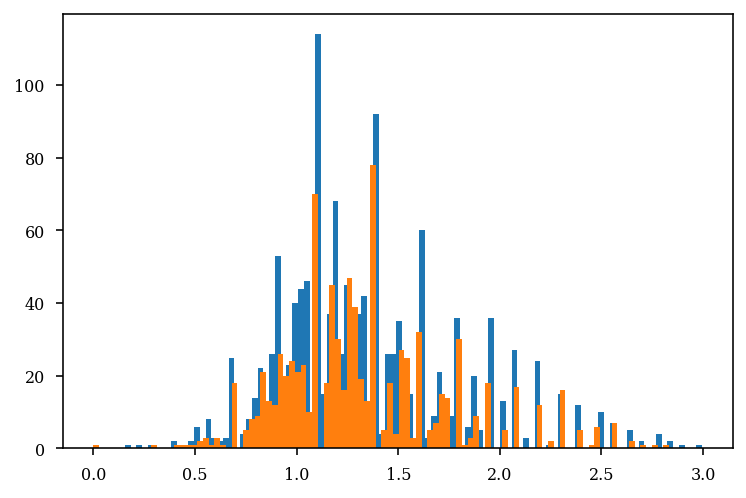

In [89]:
plt.hist(y_train,100)
plt.hist(y_test,100)
plt.show()

In [100]:
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_test, y_test))
print(reg.score(X_train, y_train))

pred = reg.predict(X_test)

mse = mean_squared_error(y_test, pred)
print(mse)

scores = cross_val_score(reg, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.0884801077633075
0.16137496394219086
0.1617710252339742
[-0.03374946 -0.03251741  0.01557499  0.0296914  -0.02521706]
-0.01 accuracy with a standard deviation of 0.03


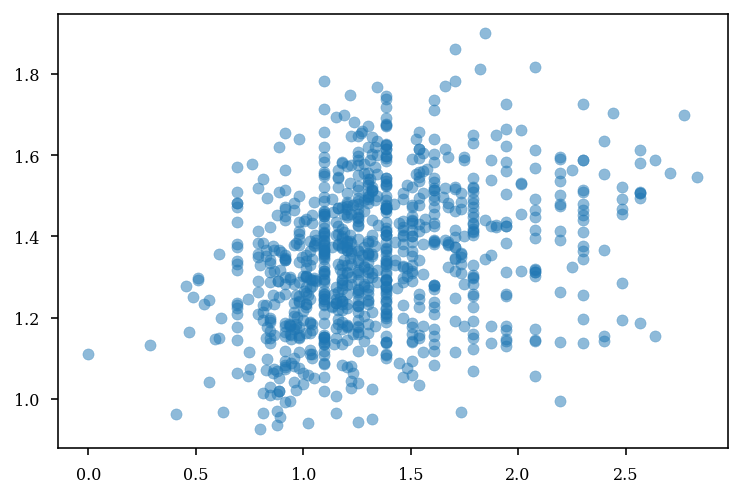

In [30]:
plt.scatter(y_test,pred,alpha=0.5)
# plt.axis("square")
# plt.ylim(0,3)
plt.show()

In [62]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, pred)
mse

4.578292035320783

In [63]:
scores = cross_val_score(reg, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[-0.02761957 -0.06379941  0.00020244  0.02407037 -0.00402143]
-0.01 accuracy with a standard deviation of 0.03


In [83]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE

from sklearn.model_selection import GridSearchCV

# set up our search grid
param_grid = {
    "max_depth": [4, 5],
    "n_estimators": [500, 600, 700],
    "learning_rate": [0.01, 0.015],
}

regressor = xgb.XGBRegressor(seed=123, eval_metric="rmsle")

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ", search.best_params_)


The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}


In [84]:
regressor = xgb.XGBRegressor(
    learning_rate=search.best_params_["learning_rate"],
    n_estimators=search.best_params_["n_estimators"],
    max_depth=search.best_params_["max_depth"],
    eval_metric="rmsle",
)

regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)


In [85]:
print(regressor.score(X_test, y_test))
print(regressor.score(X_train, y_train))

0.06303038866539346
0.5260519674487703


In [67]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

RMSLE = np.sqrt( mean_squared_log_error(y_test, predictions))
print("The score is %.5f" % RMSLE )

mse = mean_squared_error(y_test, predictions)
mse

The score is 0.41912


4.60469053199608

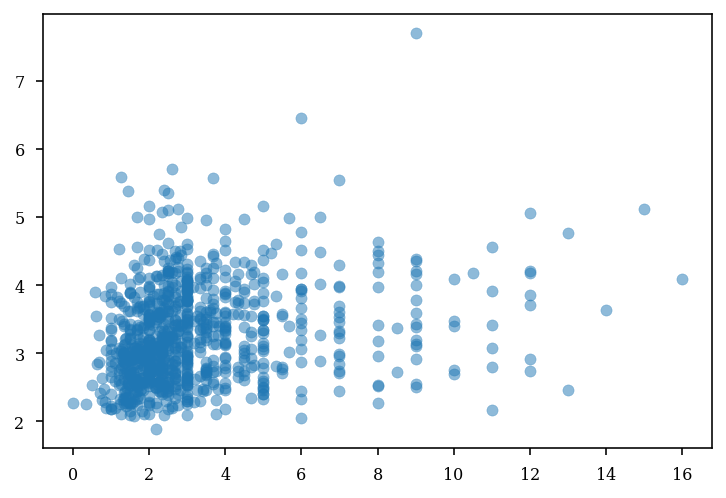

In [68]:
plt.scatter(y_test,predictions,alpha=0.5)
# plt.axis("square")
# plt.xlim(-.5,2.5)
# plt.ylim(-.5,2.5)
plt.show()

In [20]:


model = xgb.XGBRegressor(seed = 123)
# define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
# scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = cross_val_score(model, X, y, cv=5)
# scores = np.abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

model.fit(X_train, y_train)

pred = model.predict(X_test)

Mean MAE: -0.235 (0.088)


In [21]:
score = model.score(X_test, y_test) 
score

-0.13912759088730908

In [22]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, pred)
mse

5.544877058584767

(0.0, 200.0)

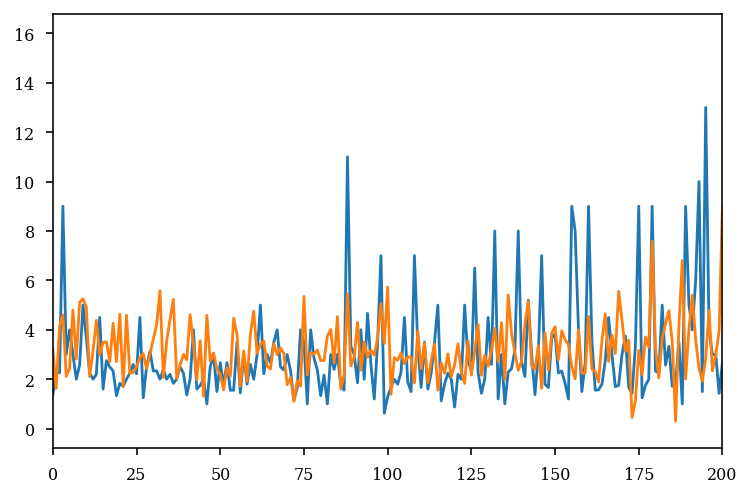

In [23]:
plt.plot(y_test)
plt.plot(pred)
plt.xlim(0,200)

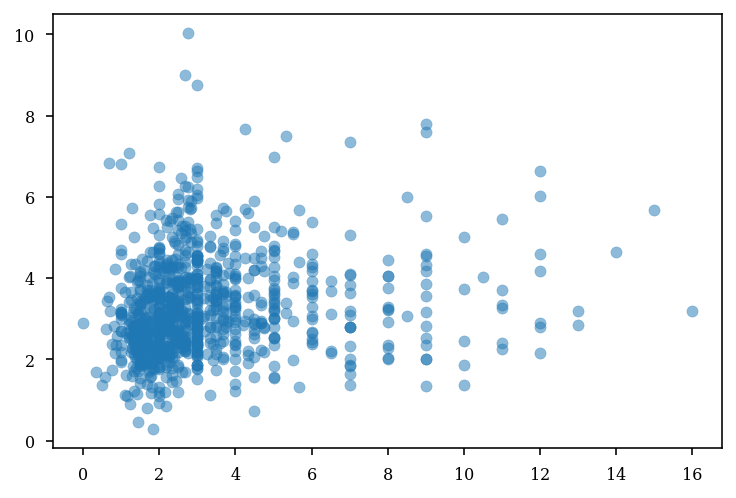

In [24]:
plt.scatter(y_test,pred,alpha=0.5)
# plt.axis("square")
# plt.xlim(-.5,2.5)
# plt.ylim(-.5,2.5)
plt.show()

In [25]:
# Train and test set are converted to DMatrix objects,
# as it is required by learning API.
train_dmatrix = xgb. (data = X_train, label = y_train)
test_dmatrix = xgb.DMatrix(data = X_test, label = y_test)
 
# Parameter dictionary specifying base learner
param = {"booster":"gblinear", "objective":"reg:squarederror"}
 
xgb_r = xgb.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
pred = xgb_r.predict(test_dmatrix)
 
# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

RMSE :  2.237715


In [33]:
# xgb_r.get_score()

In [27]:
mse = mean_squared_error(y_test, pred)
mse

5.007368659984908

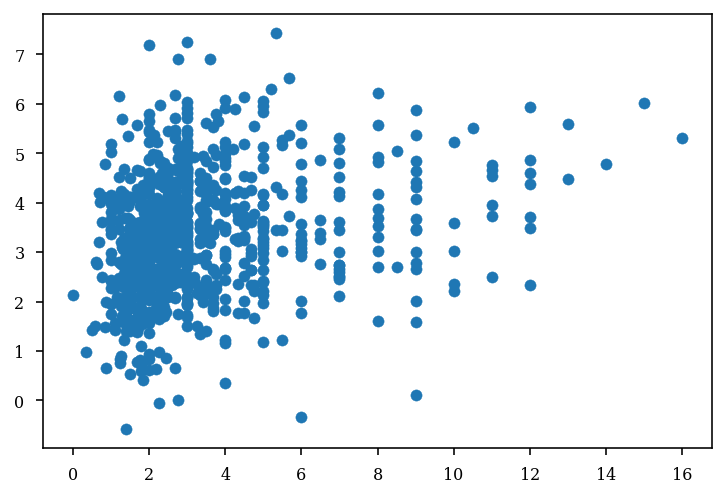

In [26]:
plt.scatter(y_test,pred)
# plt.axis("square")

In [ ]:
reg = Lasso().fit(X_train, y_train)
reg.score(X_test, y_test)

-6.0279201143709216e-05

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(random_state=0)
reg = BaggingRegressor(extra_tree, random_state=0).fit(
    X_train, y_train)
reg.score(X_test, y_test)

-0.20827310041102876

In [ ]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((2614, 23), (2614, 1), (3920, 23), (3920, 1))

In [ ]:


reg = make_pipeline(preprocessing.StandardScaler(), BaggingRegressor(extra_tree, random_state=0))

scores = cross_val_score(reg, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[-0.25122904 -0.19895562 -0.41078681 -0.20635456 -0.16995342]
-0.25 accuracy with a standard deviation of 0.09


In [136]:
from elephant.causality.granger import pairwise_granger
pairwise_granger(np.random.uniform(size=(1000, 2)), max_order=2)


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\causality\granger.py:494: UserWarning: The value of the log determinant is at or below the tolerance level. Proceeding with computation.


Causality(directional_causality_x_y=0.0, directional_causality_y_x=0.01, instantaneous_causality=0.0, total_interdependence=0.01)

In [167]:
x = np.random.randn(1001)
y = 3.5 * x[:-1] + np.random.randn(1000)
signals = np.array([x[1:], y]).T  # N x 2 matrix
pairwise_granger(signals, max_order=1)

Causality(directional_causality_x_y=2.47, directional_causality_y_x=0.0, instantaneous_causality=0.0, total_interdependence=2.47)

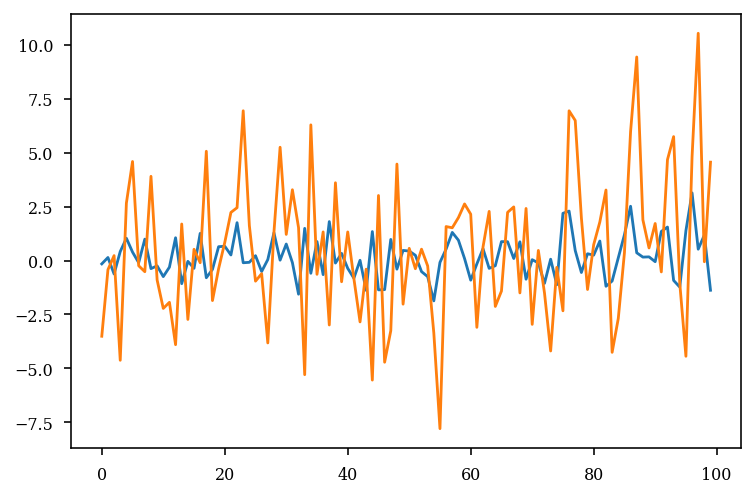

In [174]:
plt.plot(signals[0:100,0])
plt.plot(signals[0:100,1])

In [202]:
directional_causality_x_y = []
for x in X_test.T:
    signals = np.hstack([y_test.reshape(-1,1),x.reshape(-1,1)])
    out = pairwise_granger(signals, max_order=1)
    # signals
    # X_test.shape, y_test.shape
    directional_causality_x_y.append(out.directional_causality_x_y)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\causality\granger.py:494: UserWarning: The value of the log determinant is at or below the tolerance level. Proceeding with computation.


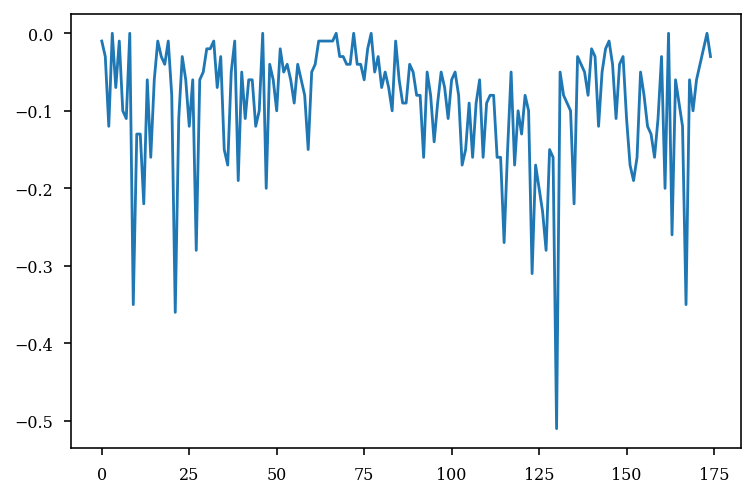

In [204]:
plt.plot(directional_causality_x_y)

(0.0, 100.0)

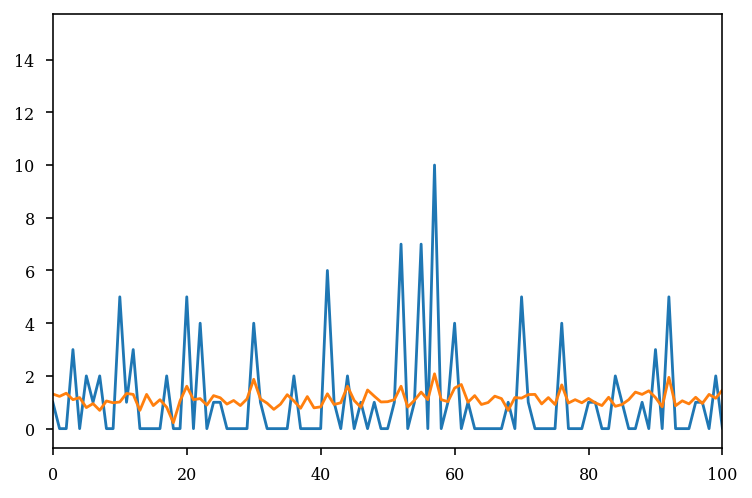

In [215]:
np.argmin(directional_causality_x_y)

    # signals = np.hstack([y_test.reshape(-1,1),.reshape(-1,1)])
plt.plot(X_test[:,np.argmax(directional_causality_x_y)])
plt.plot(y_test)
plt.xlim(0,100)